# Spotify Mood Session

## 1. Algorithm

a. **First Selection**. User selects a song $s_0$ from the set of all songs $S$ using some kind of search method (by name / artist) and plays that song.

b. **Played List**.  Let $P$ be a new list of played songs and let $P \gets s_0$   

c. **Cold Start**. Create a bootstrap random selection of $n$ songs from $S$ called $R$. Calculate the distance between each song and the first selection and select the closest to the chosen song . Formally:

$$
\forall s \in R \text{ dist}(s_i, s_0)
$$

*potential parameter: use a value to add the closest n songs to the initial bootstrap played list*

d. **Rating**. For every song that a user plays for more than 30 seconds, the song is rated $\text{pos}$, songs that are skipped within this time period are rated $\text{neg}$.  Songs that have not been played are rated $\text{non}$

e. **Recommending**.  Take the current set of vectors and select the next song based on some sort of agregated mean or nearest neighbour system.

repeat (d) and (e) ad infinitum.

Formally:

$$
\text{let: } s_0 \gets \text{ user}(S) \\
\text{let: } P = \{ s_0 \} \\
\text{let: } R \subset S \\
\text{let: } D = \emptyset \\ 
\text{for } s_i \text{ in } R:\\
D_i = \text{dist}(s_i, s_0) \\
\text{end for }\\
\text{select}(\text{max}(D))\\
$$

In [1]:
import json
import pandas as pd
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials as cc
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
import time

# create list of playlists
playlists = []
path = 'data'
count = 5
for filename in os.listdir(path):
    count -= 1
    if count < 0:
        break
    f = os.path.join(path, filename)
    if os.path.isfile(f):
        d = json.load(open(f))
        playlists.append(pd.DataFrame(d['playlists']))

playlists = pd.concat(playlists)
playlists = playlists.reset_index(drop=True)
print(playlists.shape)

(5000, 12)


In [2]:
# Add all songs from the playlists into a single list of songs
songs = [] 
for i in range(len(playlists)):
    tracks = playlists.iloc[i].loc['tracks']
    for track in tracks:
        songs.append(track)

songs_df = pd.DataFrame(songs)
print(songs_df.shape)
songs_df.head()

(334487, 8)


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,Original Broadway Cast - The Little Mermaid,spotify:track:5IbCV9Icebx8rR6wAp5hhP,spotify:artist:3TymzPhJTMyupk7P5xkahM,Fathoms Below - Broadway Cast Recording,spotify:album:3ULJeOMgroG27dpn27MDfS,154506,The Little Mermaid: Original Broadway Cast Rec...
1,1,Original Broadway Cast - The Little Mermaid,spotify:track:6rKVAvjHcxAzZ1BHtwh5yC,spotify:artist:3TymzPhJTMyupk7P5xkahM,Daughters Of Triton - Broadway Cast Recording,spotify:album:3ULJeOMgroG27dpn27MDfS,79066,The Little Mermaid: Original Broadway Cast Rec...
2,2,Original Broadway Cast - The Little Mermaid,spotify:track:6Jlkb1Wh08RYHstWScsTvg,spotify:artist:3TymzPhJTMyupk7P5xkahM,The World Above - Broadway Cast Recording,spotify:album:3ULJeOMgroG27dpn27MDfS,94600,The Little Mermaid: Original Broadway Cast Rec...
3,3,Original Broadway Cast - The Little Mermaid,spotify:track:0XhC8bfStML9ygBmfOt1JJ,spotify:artist:3TymzPhJTMyupk7P5xkahM,Human Stuff - Broadway Cast Recording,spotify:album:3ULJeOMgroG27dpn27MDfS,151480,The Little Mermaid: Original Broadway Cast Rec...
4,4,Original Broadway Cast - The Little Mermaid,spotify:track:0ABxAcsRWlqckkyONsfP67,spotify:artist:3TymzPhJTMyupk7P5xkahM,I Want the Good Times Back - Broadway Cast Rec...,spotify:album:3ULJeOMgroG27dpn27MDfS,297920,The Little Mermaid: Original Broadway Cast Rec...


In [3]:
# Remove duplicate songs by URI
songs_df = songs_df.drop_duplicates('track_uri')

In [4]:
# Add score placeholder to the songs
classification = [0]*len(songs_df)
songs_df.insert(8, "class", classification) # Append data frame by one column

In [5]:
# Print song data to ensure the score was added
print(songs_df.iloc[0])

pos                                                            0
artist_name          Original Broadway Cast - The Little Mermaid
track_uri                   spotify:track:5IbCV9Icebx8rR6wAp5hhP
artist_uri                 spotify:artist:3TymzPhJTMyupk7P5xkahM
track_name               Fathoms Below - Broadway Cast Recording
album_uri                   spotify:album:3ULJeOMgroG27dpn27MDfS
duration_ms                                               154506
album_name     The Little Mermaid: Original Broadway Cast Rec...
class                                                          0
Name: 0, dtype: object


In [6]:
#DO NOT RUN THE AUDIO FEATURES HAVE ALREADY BEEN STORED IN THE AUDIO_FEATURES FILE
def run_features():
    #CREATE DATASET WITH SONG AUDIO FEATURES FROM THE URIS OF songs_df
    client_id = '898dd71dc932407e85921f0ac79f0127'
    client_secret = '16d994f070064371beb8758f32d64180'
    #https://developer.spotify.com/dashboard/applications/898dd71dc932407e85921f0ac79f0127
    client_cc = cc(client_id=client_id,client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_cc)


    sleep_min = 1
    sleep_max = 2
    start_time = time.time()
    request_count = 0
    tracks_w_features = pd.DataFrame()
    for i in range(0,3344):
        if request_count % 13 == 0:
            time.sleep(np.random.uniform(sleep_min, sleep_max))
        else:
            tracks_to_get = songs_df.iloc[request_count:request_count+100]["track_uri"] #get the uri of these songs to get audio features
            tracks = pd.DataFrame(sp.audio_features(tracks_to_get))
            tracks_w_features = tracks_w_features.append(tracks)
        request_count+=100

    #remove useless-categorical columns, can use index to get song information later
    tracks_w_features = tracks_w_features.drop(columns=['mode','key','time_signature', 'duration_ms','analysis_url','track_href','id','type']).copy()
    warnings.filterwarnings("ignore")
    warnings.filterwarnings(action='once')

    from pathlib import Path
    filepath = Path('recommender-systems/audio_features.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    tracks_w_features.to_csv(filepath)

In [7]:
def merge():
    tracks_w_features = pd.read_csv('recommender-systems/audio_features.csv')
    tracks_w_features = tracks_w_features.drop(columns=['Unnamed: 0','0','instrumentalness','loudness','speechiness'])
    tracks_w_features = tracks_w_features.rename(columns={"uri": "track_uri"})
    display(songs_df.head())
    display(tracks_w_features.head())


    songs = pd.merge(songs_df, tracks_w_features, on='track_uri')
    display(songs)

    from pathlib import Path
    filepath = Path('recommender-systems/allsongs.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    songs.to_csv(filepath)

In [8]:
# Load the songs from the CSV file
songs = pd.read_csv('recommender-systems/allsongs.csv')
songs = songs.drop(columns=['Unnamed: 0','pos'])
display(songs)

,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,class,acousticness,danceability,energy,liveness,tempo,valence
0,Zion.T,spotify:track:6ToAD7ajJidQTDn72OncDG,spotify:artist:5HenzRvMtSrgtvU16XAoby,꺼내 먹어요 (Eat),spotify:album:3JdBY835ai83ZEVwvBsIDN,161624,꺼내 먹어요 (Eat) - Single,0,0.5440,0.6280,0.284,0.1210,91.131,0.3540
1,Zion.T,spotify:track:6yEfq48XkEzCg0TwY6Hhkb,spotify:artist:5HenzRvMtSrgtvU16XAoby,No Make Up,spotify:album:5vudrVEnoTqgAgATgafUL2,189154,No Make Up - Single,0,0.4110,0.7580,0.402,0.2170,92.109,0.5190
2,KARD,spotify:track:1ZgfAxHQCXLt8o1VXEHHAt,spotify:artist:2JhAlkmukNvarUpGhTFXUQ,Oh NaNa (Hidden. HUR YOUNG JI),spotify:album:2HpryOOYLbnST4aCT5v4lF,206772,"K.A.R.D Project Vol.1 ""Oh NaNa""",0,0.0615,0.7560,0.922,0.0723,100.005,0.8090
3,KARD,spotify:track:4b1sQpvL7QVgamRZ74F1oA,spotify:artist:2JhAlkmukNvarUpGhTFXUQ,Don't Recall,spotify:album:4wTkdR3v9qFdRuCf2hpBZn,208666,"K.A.R.D Project Vol.2 ""Don't Recall""",0,0.0222,0.6940,0.748,0.1550,92.918,0.5210
4,Zion.T,spotify:track:0AO2yQNGcH0ASHHU5lS4lT,spotify:artist:5HenzRvMtSrgtvU16XAoby,양화대교 (Yanghwa Brdg),spotify:album:06ngphQtoWwkns4H1tpXnq,229349,양화대교 (Yanghwa Brdg) - Single,0,0.7260,0.5380,0.436,0.1510,87.111,0.3700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100465,Rob Folsom,spotify:track:7rWF4voHsXhZ3lx1BgtIjq,spotify:artist:2fHYxgIBdyFUvmxsTbQ2na,The Ludlows,spotify:album:5Q4h4AmcAw0tElWXQbQMqO,240927,Sentimental Serenade,0,0.9470,0.2980,0.164,0.1390,79.968,0.1010
100466,Jay Ungar,spotify:track:5YUeOSawPzseEvCvi1HbrE,spotify:artist:54jNT6jMGDoxMSBzUDEYSB,Cows On The Hill,spotify:album:38D9S6sriWlYlbUBONInpa,225440,"Waltzing With You (Music From The Film ""Brothe...",0,0.7230,0.1120,0.157,0.2120,92.197,0.0864
100467,Solas,spotify:track:4aAmDp1AR1Fp1UCpWuvy2d,spotify:artist:2CGGUtRYybRjQmuUwXugeP,Crested Hens,spotify:album:1EL10LDAWFZdencyTUlGqu,314186,Solas,0,0.4200,0.1690,0.209,0.0985,78.355,0.1020
100468,Kim Yoon,spotify:track:25JRhSij3kxAJ1li9lPe5k,spotify:artist:2wA50FpX5Yc5b4OrhdQVXP,Moonlight Waltz,spotify:album:6pFFE9TLlHpeQrvOVNiswy,226925,Dreaming in the Blue Sky,0,0.9050,0.4650,0.156,0.1290,83.021,0.1820


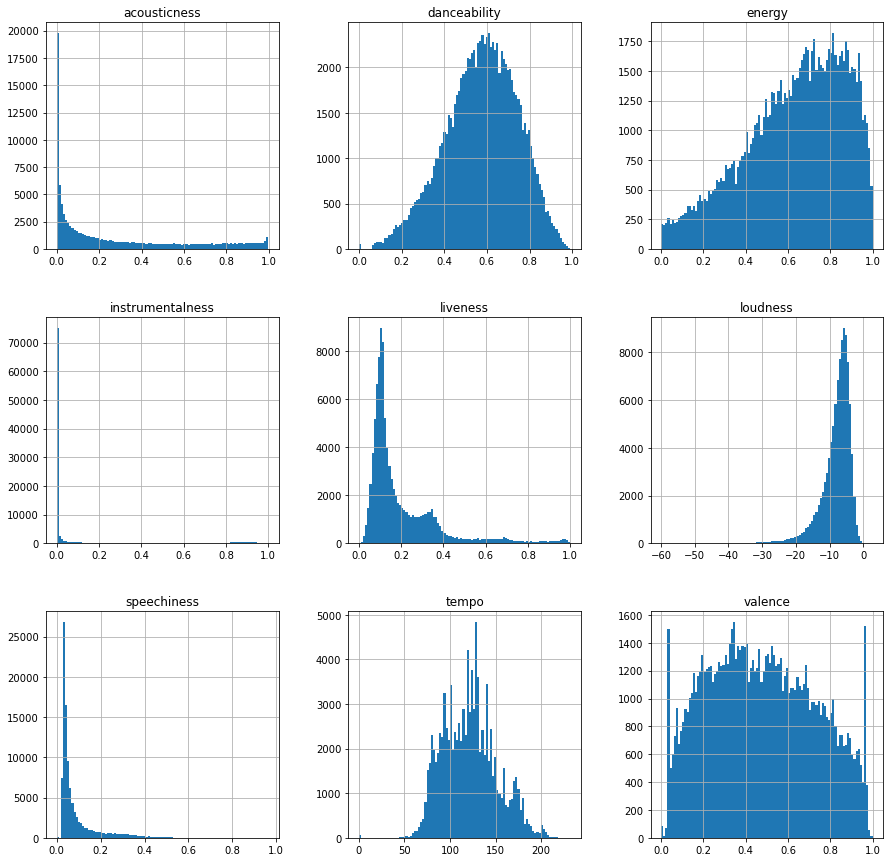

In [9]:
# Investigate data distributions
tracks_w_features = pd.read_csv('recommender-systems/audio_features.csv')
tracks_w_features = tracks_w_features.drop(columns=['Unnamed: 0','0'])
tracks_w_features.hist(figsize=(15,15), bins=100);

In [10]:
import max_marg_relevance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import laplacian_kernel

def getRecommendation(songs):
    liked_songs = songs.loc[songs['class'] == 1]
    average_session_songs = liked_songs[['acousticness','danceability','energy','liveness','tempo','valence']].mean()
    songs_to_recommend_from = songs.sample(n=20)
    songs_to_recommend_from =songs_to_recommend_from.filter(['acousticness','danceability','energy','liveness','tempo','valence','track_uri'])
    return maximal_marginal_relevance(average_session_songs,songs_to_recommend_from)

def maximal_marginal_relevance(v1,songs_to_compare, lambda_constant=0.5, threshold_terms=1, sim = True):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param v1: query vector
    :param songs: matrix having index as songs and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked songs with score
    """
    s = []
    r = songs_to_compare['track_uri'].tolist()
    while len(r) > 0:
        score = 0
        song_to_add = None
        for i in r:
            row = songs_to_compare.loc[songs_to_compare['track_uri'] == i]
            row = row.drop(columns=['track_uri'])
            row = row.to_numpy()
            if len(row) < 1:
              r.remove(i)
              break
            if sim:
                first_part = cosine_similarity([v1], [row[0]])
            else:
                first_part = laplacian_kernel([v1], [row[0]])
            second_part = 0
            for j in s:
                row2 = songs_to_compare.loc[songs_to_compare['track_uri'] == j[0]]
                row2 = row2.drop(columns=['track_uri'])
                row2 = row2.to_numpy()
                if sim:
                    sim = cosine_similarity([row[0]],[row2[0]])
                else:
                    sim = laplacian_kernel([row[0]], [row2[0]])
                if sim > second_part:
                    second_part = sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                song_to_add = i
        if song_to_add is None:
            song_to_add = i
        r.remove(song_to_add)
        s.append((song_to_add, score))
    return s[:threshold_terms][0][0]

In [11]:
# Search for a particular song 
print("Search for a song name")
s = input()
pattern = [s]

# filter for rows that contain the partial string inputted by the user
results = songs.copy()
results[songs.track_name.str.contains('|'.join(pattern))]

Search for a song name



,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,class,acousticness,danceability,energy,liveness,tempo,valence
0,Zion.T,spotify:track:6ToAD7ajJidQTDn72OncDG,spotify:artist:5HenzRvMtSrgtvU16XAoby,꺼내 먹어요 (Eat),spotify:album:3JdBY835ai83ZEVwvBsIDN,161624,꺼내 먹어요 (Eat) - Single,0,0.5440,0.6280,0.284,0.1210,91.131,0.3540
1,Zion.T,spotify:track:6yEfq48XkEzCg0TwY6Hhkb,spotify:artist:5HenzRvMtSrgtvU16XAoby,No Make Up,spotify:album:5vudrVEnoTqgAgATgafUL2,189154,No Make Up - Single,0,0.4110,0.7580,0.402,0.2170,92.109,0.5190
2,KARD,spotify:track:1ZgfAxHQCXLt8o1VXEHHAt,spotify:artist:2JhAlkmukNvarUpGhTFXUQ,Oh NaNa (Hidden. HUR YOUNG JI),spotify:album:2HpryOOYLbnST4aCT5v4lF,206772,"K.A.R.D Project Vol.1 ""Oh NaNa""",0,0.0615,0.7560,0.922,0.0723,100.005,0.8090
3,KARD,spotify:track:4b1sQpvL7QVgamRZ74F1oA,spotify:artist:2JhAlkmukNvarUpGhTFXUQ,Don't Recall,spotify:album:4wTkdR3v9qFdRuCf2hpBZn,208666,"K.A.R.D Project Vol.2 ""Don't Recall""",0,0.0222,0.6940,0.748,0.1550,92.918,0.5210
4,Zion.T,spotify:track:0AO2yQNGcH0ASHHU5lS4lT,spotify:artist:5HenzRvMtSrgtvU16XAoby,양화대교 (Yanghwa Brdg),spotify:album:06ngphQtoWwkns4H1tpXnq,229349,양화대교 (Yanghwa Brdg) - Single,0,0.7260,0.5380,0.436,0.1510,87.111,0.3700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100465,Rob Folsom,spotify:track:7rWF4voHsXhZ3lx1BgtIjq,spotify:artist:2fHYxgIBdyFUvmxsTbQ2na,The Ludlows,spotify:album:5Q4h4AmcAw0tElWXQbQMqO,240927,Sentimental Serenade,0,0.9470,0.2980,0.164,0.1390,79.968,0.1010
100466,Jay Ungar,spotify:track:5YUeOSawPzseEvCvi1HbrE,spotify:artist:54jNT6jMGDoxMSBzUDEYSB,Cows On The Hill,spotify:album:38D9S6sriWlYlbUBONInpa,225440,"Waltzing With You (Music From The Film ""Brothe...",0,0.7230,0.1120,0.157,0.2120,92.197,0.0864
100467,Solas,spotify:track:4aAmDp1AR1Fp1UCpWuvy2d,spotify:artist:2CGGUtRYybRjQmuUwXugeP,Crested Hens,spotify:album:1EL10LDAWFZdencyTUlGqu,314186,Solas,0,0.4200,0.1690,0.209,0.0985,78.355,0.1020
100468,Kim Yoon,spotify:track:25JRhSij3kxAJ1li9lPe5k,spotify:artist:2wA50FpX5Yc5b4OrhdQVXP,Moonlight Waltz,spotify:album:6pFFE9TLlHpeQrvOVNiswy,226925,Dreaming in the Blue Sky,0,0.9050,0.4650,0.156,0.1290,83.021,0.1820


In [ ]:
# --- Start and simulate a session ---

DEBUG = false

# Ask the user to enter a track URI for the first song they want to play
print("Select your first song by copying the track_URI from above (i.e. spotify:track:2wSAWEYUHkt92X4SBAPqZE)")

# !!! Uncomment to allow user to select first song !!!
if DEBUG:
    s = "spotify:track:6bLopGnirdrilrpdVB6Um1"
else:
    s = input() 


# Mark this song as "Played" with a positive rating (as the user chose it)
index = songs.index[songs['track_uri'] == s]     # This returns the song with the uri of 's'

continue_ = True
current_song_index = songs.index[songs['track_uri'] == s].tolist()[0]
avg_features = [0]*6 # stores the average of each feature in the current session
session_length = 0

while continue_:
    session_length += 1
    print("-------- Track 1:", session_length, "--------")
    current_song_artist = songs.iloc[current_song_index]["artist_name"]
    current_song_name = songs.iloc[current_song_index]["track_name"]

    # --- Explanation ---

    # Update average feature vector (incremental averaging)

    # 1 - accousticness
    feature_1 = songs.iloc[current_song_index]["acousticness"]
    avg_features[0] = avg_features[0] + ((feature_1 - avg_features[0]) / session_length)

    # 2 - danceability
    feature_2 = songs.iloc[current_song_index]["danceability"]
    avg_features[1] = avg_features[1] + ((feature_2 - avg_features[1]) / session_length)

    # 3 - energy
    feature_3 = songs.iloc[current_song_index]["energy"]
    avg_features[2] = avg_features[2] + ((feature_3 - avg_features[2]) / session_length)

    # 4 - liveness
    feature_4 = songs.iloc[current_song_index]["liveness"]
    avg_features[3] = avg_features[3] + ((feature_4 - avg_features[3]) / session_length)

    # 5 - tempo
    feature_5 = songs.iloc[current_song_index]["tempo"] / 250 # normalise
    avg_features[4] = avg_features[4] + ((feature_5 - avg_features[4]) / session_length)

    # 6 - valence
    feature_6 = songs.iloc[current_song_index]["valence"]
    avg_features[5] = avg_features[5] + ((feature_6 - avg_features[5]) / session_length)

    # Find smallest difference
    current_features = [feature_1, feature_2, feature_3, feature_4, feature_5, feature_6]
    difference_vector = [0] * 6
    for i in range(len(difference_vector)):
        difference_vector[i] = current_features[i] - difference_vector[i]
        if difference_vector[i] < 0:
            difference_vector *= -1

    print("Average feature vector:", avg_features)
    print("Current feature vector:", current_features)

    # Generate explanation string
    min_index = difference_vector.index(min(difference_vector))
    selected_feature = "ERROR" # Default value

    if min_index == 0:
        selected_feature = "acousticness"
    if min_index == 1:
        selected_feature = "danceability"
    if min_index == 2:
        selected_feature = "energy"
    if min_index == 3:
        selected_feature = "liveness"
    if min_index == 4:
        selected_feature = "tempo"
    if min_index == 5:
        selected_feature = "valence"

    explanation_string = "This song was chosen because the %s fits your session best.\n\n" % selected_feature
    if session_length == 1:
        explanation_string = ""

    # --- Main loop ---

    in_ = input(explanation_string + current_song_artist + "-" + current_song_name + "\n\n" + "Listen (y) or skip (n) or quit (q)?")

    if in_ == "n":
        print("skipped")
        songs.at[current_song_index, "class"] = -1 # negative rating
    elif in_ == "y":
        print("not skipped")
        songs.at[current_song_index, "class"] = 1  # positive rating
    elif in_ == "q":
        print("quit session")
        continue_ = False
    else:
        print("Invalid input")
    uri = getRecommendation(songs)
    current_song_index = songs.index[songs["track_uri"] == uri].tolist()[0] # TODO: Change to get next recommended song index (of songs data frame)


Select your first song by copying the track_URI from above (i.e. spotify:track:2wSAWEYUHkt92X4SBAPqZE)
-------- Track 1: 1 --------
Average feature vector: [0.0174, 0.639, 0.785, 0.0512, 0.7677999999999999, 0.686]
Current feature vector: [0.0174, 0.639, 0.785, 0.0512, 0.7677999999999999, 0.686]
Sia-The Greatest

Listen (y) or skip (n) or quit (q)?y
not skipped
-------- Track 1: 2 --------
Average feature vector: [0.018099999999999998, 0.6435, 0.6890000000000001, 0.1101, 0.7058679999999999, 0.7025]
Current feature vector: [0.0188, 0.648, 0.593, 0.169, 0.6439360000000001, 0.719]
This song was chosen because the acousticness fits your session best.

Beyoncé-Party

Listen (y) or skip (n) or quit (q)?n
skipped
-------- Track 1: 3 --------
Average feature vector: [0.016233333333333332, 0.6143333333333333, 0.6903333333333334, 0.09516666666666666, 0.6652826666666666, 0.644]
Current feature vector: [0.0125, 0.556, 0.693, 0.0653, 0.584112, 0.527]
